In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # visualization
import tensorflow as tf # Deep Learning Framework

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Import the data - Includes ~14k train images and 3k test images of size 150x150 of natural scenes**

In [3]:
test_dir = '../input/intel-image-classification/seg_test/seg_test/'
train_dir = '../input/intel-image-classification/seg_train/seg_train/'

In [3]:
# Load data from directory and turn them into batches
train_batchdf = tf.keras.preprocessing.image_dataset_from_directory(
                                    directory=train_dir,
                                    image_size=(150, 150),     # Taken from data description - 150x150 
                                    label_mode="categorical",  # Taken from data description - 6 categories
                                    batch_size=64)             # Size of the batches of data - important for # of steps_per_epochs
test_batchdf = tf.keras.preprocessing.image_dataset_from_directory(
                                    directory=test_dir,
                                    image_size=(150, 150),
                                    label_mode="categorical",
                                    batch_size=64)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


**Lets confirm the class names**

In [4]:
class_names = train_batchdf.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


**Output some of the pictures**

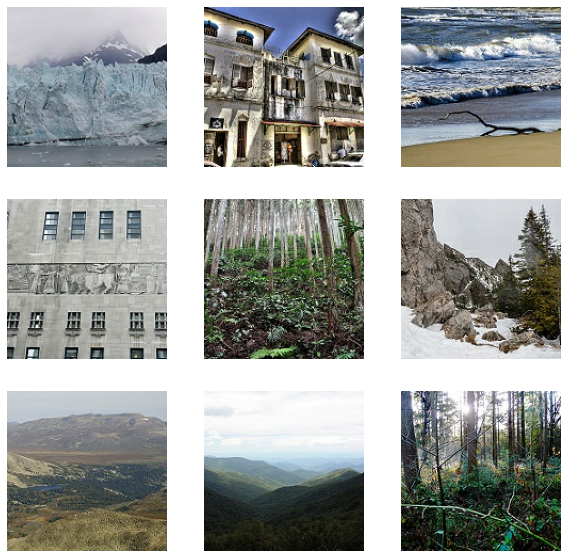

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_batchdf.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

# **Lets create a CNN model from scratch**

In [6]:
# Create the model and define all layers
input_shape_arg=(150, 150, 3)     # Dimension of the input with 3 color channels (RGB)
model_cnn = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),    # Rescale input range to be [0, 1]
    # 2D convolution layer (e.g. spatial convolution over images)
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape_arg),  
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),    # Downsamples the input along its spatial dimensions
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [7]:
# Compile the model
model_cnn.compile(loss=tf.keras.losses.CategoricalCrossentropy(),   # Since the label_mode is categorical
              optimizer=tf.keras.optimizers.Adam(),                 # Optimizer of choice - implements the Adam algorithm.
              metrics=['accuracy'])

In [8]:
# Fit the model
history_cnn = model_cnn.fit(train_batchdf,
                            epochs=10,
                            steps_per_epoch=len(train_batchdf), # Want to run every training batch
                            validation_data=test_batchdf,
                            validation_steps=len(test_batchdf)) # Want to run every testing batch

Epoch 1/10
220/220 [==============================] - 178s 781ms/step - loss: 1.5091 - accuracy: 0.3735 - val_loss: 0.9813 - val_accuracy: 0.6307
Epoch 2/10
220/220 [==============================] - 101s 456ms/step - loss: 1.1090 - accuracy: 0.5434 - val_loss: 0.8401 - val_accuracy: 0.6567
Epoch 3/10
220/220 [==============================] - 100s 455ms/step - loss: 0.9530 - accuracy: 0.6044 - val_loss: 0.7217 - val_accuracy: 0.7297
Epoch 4/10
220/220 [==============================] - 101s 455ms/step - loss: 0.8798 - accuracy: 0.6388 - val_loss: 0.7251 - val_accuracy: 0.7380
Epoch 5/10
220/220 [==============================] - 101s 455ms/step - loss: 0.8107 - accuracy: 0.6776 - val_loss: 0.6259 - val_accuracy: 0.7767
Epoch 6/10
220/220 [==============================] - 100s 455ms/step - loss: 0.7584 - accuracy: 0.7041 - val_loss: 0.5767 - val_accuracy: 0.7913
Epoch 7/10
220/220 [==============================] - 100s 455ms/step - loss: 0.6630 - accuracy: 0.7429 - val_loss: 0.5952 -

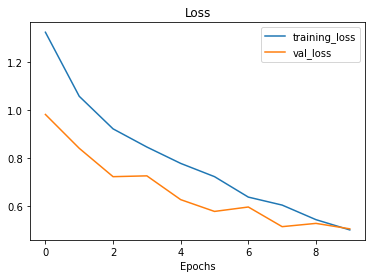

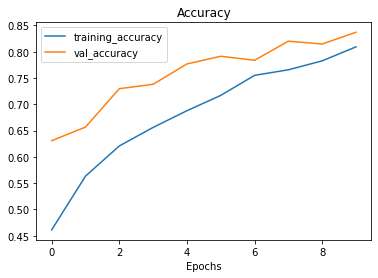

In [9]:
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']
epochs = range(len(history_cnn.history['loss']))
# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()
# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

# **Now lets try a pre-trained model from keras - Transfer learning**

In [4]:
model_resnet = tf.keras.applications.ResNet50(include_top=False,       # Remove the last dense layer
                                              input_shape=(224,224,3), # Resenet default input shape
                                              weights='imagenet')      # Use the weights from imagenet
model_resnet.trainable = False

94773248/94765736 [==============================] - 0s 0us/step


In [5]:
# Load data from directory and turn them into batches
train_batch = tf.keras.preprocessing.image_dataset_from_directory(
                                    directory=train_dir,
                                    image_size=(224, 224),     # Resize for ResNet model input - 224x224 
                                    label_mode="categorical",  # Taken from data description - 6 categories
                                    batch_size=64)             # Size of the batches of data - important for # of steps_per_epochs
test_batch = tf.keras.preprocessing.image_dataset_from_directory(
                                    directory=test_dir,
                                    image_size=(224, 224),
                                    label_mode="categorical",
                                    batch_size=64)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [6]:
# custom modifications on top of pre-trained model and fit
clf_model = tf.keras.models.Sequential()
clf_model.add(model_resnet)
clf_model.add(tf.keras.layers.Flatten()) #  Flatten the output of the convolutional layers to create a single long feature vector
clf_model.add(tf.keras.layers.Dense(6, activation='softmax')) # Use a custom output dense layer that matches # of categories
clf_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [8]:
history_resnet = clf_model.fit(train_batch,
                        epochs=10,
                        steps_per_epoch=len(train_batch), # Want to run every training batch
                        validation_data=test_batch,
                        validation_steps=len(test_batch)) # Want to run every testing batch) 

Epoch 1/10
220/220 [==============================] - 104s 440ms/step - loss: 5.3189 - accuracy: 0.7921 - val_loss: 2.4121 - val_accuracy: 0.8983
Epoch 2/10
220/220 [==============================] - 54s 243ms/step - loss: 1.4794 - accuracy: 0.9267 - val_loss: 2.7485 - val_accuracy: 0.9053
Epoch 3/10
220/220 [==============================] - 54s 243ms/step - loss: 0.8954 - accuracy: 0.9522 - val_loss: 2.9553 - val_accuracy: 0.9040
Epoch 4/10
220/220 [==============================] - 54s 242ms/step - loss: 0.5775 - accuracy: 0.9693 - val_loss: 3.1173 - val_accuracy: 0.9137
Epoch 5/10
220/220 [==============================] - 54s 243ms/step - loss: 0.3547 - accuracy: 0.9808 - val_loss: 3.7451 - val_accuracy: 0.9050
Epoch 6/10
220/220 [==============================] - 54s 244ms/step - loss: 0.3100 - accuracy: 0.9838 - val_loss: 4.4266 - val_accuracy: 0.8987
Epoch 7/10
220/220 [==============================] - 54s 241ms/step - loss: 0.3411 - accuracy: 0.9844 - val_loss: 5.3064 - val_a

In [9]:
# Lets check out the layers of our customized ResNet CNN
clf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 6)                 602118    
Total params: 24,189,830
Trainable params: 602,118
Non-trainable params: 23,587,712
_________________________________________________________________


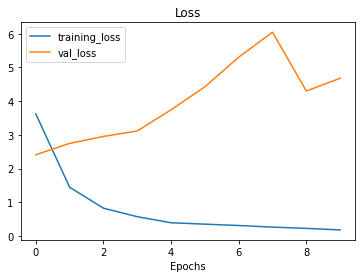

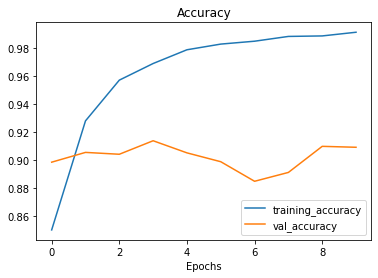

In [10]:
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy']
epochs = range(len(history_resnet.history['loss']))
# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()
# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();